# Quality analysis of crystallographic structures in the PDB

The following notebook presents the reproducible code for analyzing the quality of crystallographic structures in Protein Data Bank (PDB). The code contains comments concerning each step of the analysis, and can be considered a supplemental material for the paper *On the evolution of the quality of crystallographic models in the PDB* by Brzezinski *et al.*

The analysis was coded with Python 3.7.3 using the modules listed below. The full environment specification including module versions is provided in the `requirements.txt` in the root of the GitHub repository (https://github.com/dabrze/pdb_structure_quality).

In [1]:
# data wrangling and machine learning
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_palette("deep")
from plotnine import *
import plotnine.options
plotnine.options.figure_size = (10, 5)

# utils
import itertools
import warnings
from IPython.display import display

## Inital data cleaning

The data for this analysis was taken from the PDB as of 24 September 2018. Three files containing raw PDB metadata can be found in the `data` folder:

- `pdb_quality.fwf` contains information (fixed-width format) about:
    - the PDB code, 
    - structure resolution, 
    - date of deposition
    - R free,
    - clashscore
    - Ramachandran outliers
    - Rotamer outliers, 
    - RSR Z-score;
- `pdb_r.fwf` is a supplemental file containing information about the R-factor and contains the following columns:
    - PDB code, 
    - resolution, 
    - R-factor
    - R free;
- `pdb_journals.fwf` contains information about publications connected with PDB deposits, with columns representing:
    - the PDB code,
    - journal ISSN (or e-ISSN), 
    - journal name, 
    - journal volume
    - article page numbers,
    - publication year.
    
The following code reads the three above-mentioned dataset into pandas dataframes. For comparison purposes, the list of unique journal names prior to any normalization will be saved to `unique_journals_before.csv` in the `results` folder.

In [2]:
quality_df_raw = pd.read_fwf("data/pdb_quality.fwf",
                             names=["PDB code", "Resolution", "Date", 
                                    "Rfree_percentile_abs", "Clash_percentile_abs", "Ramachandran_percentile_abs", "Rota_percentile_abs", "RSRZ_percentile_abs", 
                                    "Rfree_percentile_rel", "Clash_percentile_rel", "Ramachandran_percentile_rel", "Rota_percentile_rel", "RSRZ_percentile_rel", 
                                    "R free", "Clashscore", "Ramachandran outliers", "Rotamer outliers", "RSR Z-score"],
                             na_values="NotAv")

journal_df_raw = pd.read_fwf("data/pdb_journals.fwf",
                             names=["PDB code", "ISSN", "Journal",
                                    "Volume", "Page", "Publication year"],
                             widths=[4, 22, 30, 6, 6, 5])

rfactors_df_raw = pd.read_fwf("data/pdb_r.fwf", index_col=0,
                              names=["PDB code", "Resolution", "R", "R free"],
                              widths=[4, 11, 10, 6],
                              na_values="NULL")

pd.DataFrame(journal_df_raw.Journal.unique(), columns=["Journal"]).sort_values("Journal").to_csv("results/unique_journals_before.csv", index=False)

Prior to any analysis, the data needs to be preprocessed. We will remove duplicates and non X-ray structures, combine information about R-factor with the remaining quality metrics, and perform preliminary journal name unification by removing punctuation from journal names. The following code performs the described tasks.

In [3]:
def unify_names_based_on_issn(df):
    journal_catalog = {}
    grouped_df = df.groupby(["ISSN", "Journal"])

    for name, group in grouped_df:
        issn = name[0]
        journal_name = name[1]

        if issn not in journal_catalog:
            journal_catalog[issn] = journal_name
        else:
            df.loc[df.loc[:, "ISSN"] == issn, "Journal"] = journal_catalog[issn]


def clean_quality_data(df, rfactors_df):
    cleaned_df = df.copy()
    print("---------------------------")
    print("PDB structure quality dataset")
    print("---------------------------")
    print("Initial number of structures: %d" % cleaned_df.shape[0])

    print("Found %d duplicates" % np.sum(cleaned_df.duplicated()))
    cleaned_df = cleaned_df.drop_duplicates()
    cleaned_df = cleaned_df.set_index("PDB code")

    print("Removed %d non X-ray structures" % np.sum(cleaned_df.Resolution.isna()))
    cleaned_df = cleaned_df.dropna(subset=["Resolution"])

    cleaned_df.loc[:, "Year"] = cleaned_df.loc[:, "Date"].apply(str).str.slice(stop=4).apply(int)
    cleaned_df.loc[:, "Date"] = pd.to_datetime(cleaned_df.loc[:, "Date"], format="%Y%m%d", errors='ignore').dt.date
    cleaned_df = cleaned_df.loc[:, ["Resolution", "Date", "Year", "Clashscore",
                                    "Ramachandran outliers", "Rotamer outliers", "RSR Z-score"]]

    r_df = rfactors_df.copy()[~rfactors_df.index.duplicated(keep='first')].loc[:, ["R", "R free"]]
    cleaned_df = pd.merge(cleaned_df, r_df, left_index=True, right_index=True, how="left")

    print("Final number of structures: %d" % cleaned_df.shape[0])
    print("---------------------------")
    print("")

    return cleaned_df


def clean_journal_data(df, quality_df):
    cleaned_df = df.copy()
    print("---------------------------")
    print("Journal information dataset")
    print("---------------------------")
    print("Initial number of structures: %d" % cleaned_df.shape[0])

    print("Found %d duplicates" % np.sum(cleaned_df.duplicated()))
    cleaned_df = cleaned_df.drop_duplicates()
    cleaned_df = cleaned_df.set_index("PDB code")

    cleaned_df.loc[:, "ISSN"] = cleaned_df.loc[:, "ISSN"].str.slice(start=-9)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(".", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(",", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("   ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("  ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.strip()
    unify_names_based_on_issn(cleaned_df)

    print("Final number of structures: %d" % cleaned_df.shape[0])
    print("---------------------------")
    print("")

    return cleaned_df

def describe(df, rows=5):
    display(df.head(rows))
    print("Dataset rows: {}".format(df.shape[0]))
    print("Dataset columns: {}".format(df.shape[1]))

In [4]:
quality_df = clean_quality_data(quality_df_raw, rfactors_df_raw)
journal_df = clean_journal_data(journal_df_raw, quality_df)

raw_journal_count = len(journal_df_raw.loc[:, "Journal"].unique())
issn_and_name_unification_journal_count = len(journal_df.loc[:, "Journal"].unique())

---------------------------
PDB structure quality dataset
---------------------------
Initial number of structures: 143621
Found 0 duplicates
Removed 12427 non X-ray structures
Final number of structures: 131194
---------------------------

---------------------------
Journal information dataset
---------------------------
Initial number of structures: 126764
Found 25 duplicates
Final number of structures: 126739
---------------------------



The provided data describes over **{{quality_df.shape[0]}} PDB deposits** by their PDB code, resolution, deposition date, several quality metrics, either as percentiles or raw values. The attached journal data describes **{{journal_df.shape[0]}} deposits** and **initially contained {{raw_journal_count}} journal names**. After correcting punctuation and whitespace errors, and name unification using ISSNs, the number of unique journal names **went down to {{issn_and_name_unification_journal_count}}**.

The first rows of dataframes containing information about structure quality and journal publications are presented below.

In [5]:
describe(quality_df)
describe(journal_df)

,Resolution,Date,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free
PDB code,,,,,,,,,
100d,1.90,1994-12-05,1994,4.46,NaN,NaN,0.00,0.145,NaN
101d,2.25,1994-12-14,1994,17.22,NaN,NaN,NaN,0.163,0.252
101m,2.07,1997-12-13,1997,16.75,0.0,3.17,0.65,0.157,0.202
102d,2.20,1994-12-15,1994,2.49,NaN,NaN,0.00,0.155,NaN
102l,1.74,1992-09-29,1992,6.44,0.0,4.44,1.84,0.174,NaN


Dataset rows: 131194
Dataset columns: 9


,ISSN,Journal,Volume,Page,Publication year
PDB code,,,,,
2e2y,0001-4842,ACC CHEM RES,V. 40,554,2007.0
3rnd,2155-5435,ACS CATAL,NaN,NaN,2011.0
3txz,2155-5435,ACS CATAL,V. 3,2376,2013.0
3wsp,2155-5435,ACS CATAL,V. 5,150,2015.0
4gbu,2155-5435,ACS CATAL,V. 3,2376,2013.0


Dataset rows: 126739
Dataset columns: 5


## Journal name unification

Even after removing punctuation, several journal names have more than one name in the PDB metadata. The main causes of this situation are:

- there is more than one way of abbreviating a journal name (e.g., CHEM BIO CHEM vs CHEMBIOCHEM),
- the journal changed its name over time (e.g., EUR J BIOCHEM vs FEBS J).

To deal with this situation we used the levenstein distance to look for pairs of journal names that differ by 4 or less edits. This way we inspected journal names with potential typos or ambiguous abbreviations. To find journals that changed their name, we looked for journals with several structures published, that stopped publishing for at least two years having at least five distinct years with published structures.

The code below performs the analysis. The journal name pairs with levenstein distance 4 or less was saved to `levelstein.csv` and the list of of "disappearing" journals to `disappearing.csv`. The journal name mapping that resulted from manual inspection of these lists was saved to `journal_mapping.csv`. Finally, the list of unique journal names after the entire process of name unification can be found in the `unique_journals_after.csv` file.

In [6]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]


def create_levenstein_journal_list(journal_df):
    unique_journal_names = journal_df.loc[:, "Journal"].unique()
    pairs_df = pd.DataFrame(itertools.combinations(unique_journal_names, 2), columns=['J1', 'J2'])
    pairs_df.loc[:, "L"] = 0
    pairs_df.loc[:, "L"] = pairs_df.apply(lambda x: levenshtein(x.J1, x.J2), axis=1)
    
    return pairs_df

def create_disappearing_journal_list(journal_df, min_years_ago=2, min_year_count=5):
    grouped_df = journal_df.groupby(["Journal", "Publication year"])
    unique_journals = journal_df.loc[:, ["Journal", "ISSN"]].drop_duplicates(subset=["Journal"])
    
    journals = []
    min_years = []
    max_years = []
    counts = []

    for name, group in grouped_df:
        journal_name = name[0]
        year = name[1]

        if journal_name not in journals:
            journals.append(journal_name)
            min_years.append(year)
            max_years.append(year)
            counts.append(1)
        else:
            if year > max_years[-1]:
                max_years[-1] = year
           
            if year < min_years[-1]:
                min_years[-1] = year
                
            counts[-1] = counts[-1] + 1


    disappearing_df = pd.DataFrame({"Journal": journals, "Min": min_years, "Max": max_years, "Count": counts})
    disappearing_df.loc[:, "YearsAgo"] = 2018 - disappearing_df.Max

    
    
    disappearing_df = disappearing_df.loc[(disappearing_df.YearsAgo >= min_years_ago) & (disappearing_df.Count >= min_year_count), :]
    disappearing_df = pd.merge(disappearing_df, unique_journals, on="Journal", how="left")
    return disappearing_df.sort_values("Count", ascending=False)

In [7]:
max_levenstein_distance = 4

levenstein_journals_df = create_levenstein_journal_list(journal_df)
levenstein_journals_df.loc[levenstein_journals_df.L <= max_levenstein_distance, :].to_csv("results/levelstein.csv")

disappearing_journals_df = create_disappearing_journal_list(journal_df)
disappearing_journals_df.to_csv("results/disappearing.csv")

In [8]:
mapping_df = pd.read_csv("results/journal_mapping.csv", index_col=False)
mapping_dict = mapping_df.set_index('From')["To"].to_dict()
journal_df = journal_df.replace(mapping_dict).copy()
unique_journals_df = pd.DataFrame(journal_df.Journal.unique(), columns=["Journal"]).sort_values("Journal")
unique_journals_df.to_csv("results/unique_journals_after.csv", index=False)

The entire process of data cleaning (disappearing journals, levenstein distance, manual inspection) resulted in **{{unique_journals_df.shape[0]}} unique journal names** describing {{journal_df.shape[0]}} structures. 

## Missing data imputation

Unfortunately, not all PDB deposits have all quality metrics calculated.

In [9]:
quality_column_nan_ratios = quality_df.isna().sum() / quality_df.shape[0] * 100
display(quality_column_nan_ratios.to_frame(name="Missing values").style.format('{:.2f}%'))

quality_not_nan_filter = quality_df.index.isin(quality_df.dropna().index)
quality_not_nan_df = quality_df[quality_not_nan_filter]
quality_nan_df = quality_df[~quality_not_nan_filter]

quality_not_nan_ratio = quality_not_nan_df.shape[0] / quality_df.shape[0]
quality_nan_ratio = 1 - quality_not_nan_ratio

,Missing values
Resolution,0.00%
Date,0.00%
Year,0.00%
Clashscore,0.10%
Ramachandran outliers,1.89%
Rotamer outliers,2.03%
RSR Z-score,11.83%
R,2.12%
R free,6.31%


The above analysis shows that practically each quality metric has missing values, with {{quality_column_nan_ratios.loc["RSR Z-score"].round(2)}}% PDB deposits missing their RSR Z-score. Overall, there are **{{round(quality_nan_ratio * 100, 2)}}% with at least one quality metric missing**.

One could continue the analysis by omitting PDB deposits with incomplete data or try to impute missing values. Since the analyzed quality metrics are to some extent correlated with each other. We will attempt both approaches. 

Before imputing missing values, we first present the histograms for each quality metric and calculate their standard deviations, to get a gist of acceptable imputation error for each metric.

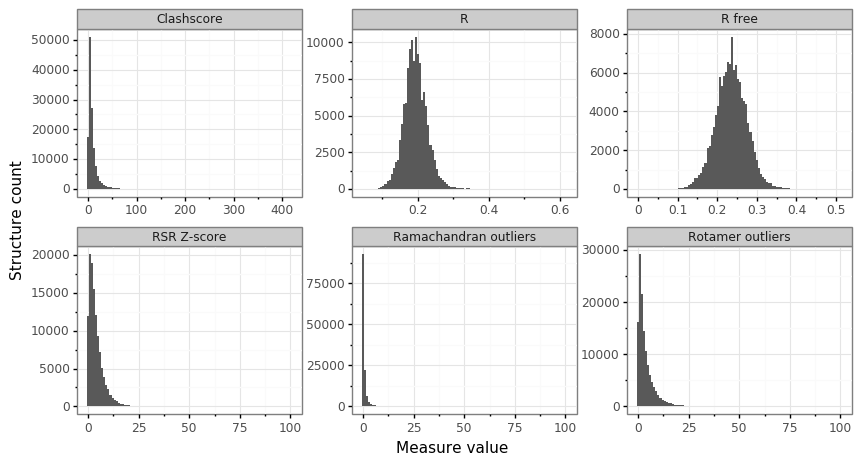

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_plot = pd.melt(quality_df, id_vars=None,
                      value_vars=["Clashscore", "R", "R free", "RSR Z-score", 
                                  "Ramachandran outliers", "Rotamer outliers"])

    p = ggplot(aes(x='value'), df_plot) + \
        geom_histogram(bins=100) + \
        theme_bw() + \
        facet_wrap("~variable", ncol=3, scales="free") + \
        ylab("Structure count") +\
        xlab("Measure value") +\
        theme(figure_size=(10, 5), panel_spacing_x=0.5,
              panel_spacing_y=0.3, legend_position="none")

    p.draw();

In [11]:
display(quality_not_nan_df.std().to_frame(name="Standard deviation"))

,Standard deviation
Resolution,0.555617
Year,4.878950
Clashscore,9.277621
Ramachandran outliers,1.243042
Rotamer outliers,3.716398
RSR Z-score,4.069144
R,0.032640
R free,0.038430


We will test three approaches to missing data imputation:

- filling missing values with the metric's mean value
- filling missing values with the metric's median
- using the iterative data imputation method of S.F. Buck described in _"A Method of Estimation of Missing Values in Multivariate Data Suitable for use with an Electronic Computer"_ with Bayesian ridge regression as the predictor. We used Bayesian ridge regression as it is a parameterless method that does not require tuning, and it was shown to perform well on such tasks.

To see how well each of the methods performs, we used the non-missing portion of the PDB data. We randomly introduced missing values to this (complete) test dataset in the same proportions as those present in the dataset, i.e., there was the same proportion of deposits with at least one missing value and the same percentage of missing values per metric as in the original (full) dataset. Next, imputed these randomly introduced missing values and compared the result with values originally present in the dataset. To quantify the imputation error we used the median absolute deviation (MAD), mean absolute error (MAE), and root mean-squared error (RMSE). The procedure was repeated 100 times, to get a better estimation of the performance of each algorithm.

In [ ]:
def introduce_random_nans(df, total_nan_pct, column_nan_pct, seed):
    naned_df = df.drop("Date", axis=1).copy()
    potential_nan_idxs = naned_df.sample(frac=total_nan_pct, random_state=seed).index
    i = seed

    for col in naned_df:
        col_frac = column_nan_pct[col] / total_nan_pct
        vals_to_nan = naned_df.loc[potential_nan_idxs, col].sample(frac=col_frac, random_state=i).index
        naned_df.loc[vals_to_nan, col] = np.NaN
        i = i + 1

    return naned_df

results_df = pd.DataFrame()

for i in range(100):
    test_df = introduce_random_nans(quality_not_nan_df, quality_nan_ratio, quality_column_nan_ratios, seed=i)
    test_idx = test_df.isna()
 
    for name, imputer in [
        ("Mean", SimpleImputer(strategy="mean")),
        ("Median", SimpleImputer(strategy="median")),
        ("Bayesian", IterativeImputer(random_state=23, max_iter=10))
    ]:       
        df_imputed = pd.DataFrame(imputer.fit_transform(test_df), columns=test_df.columns, index=test_df.index)
                    
        for col in test_df:
            if test_df[col].isna().any():
                for measure, func in [("MSE", mean_squared_error), 
                                      ("MAE", mean_absolute_error),
                                      ("MAD", median_absolute_error)]:
                    y_true = quality_not_nan_df.loc[test_idx[col], col]
                    y_pred = df_imputed.loc[test_idx[col], col]
        
                    results_df = results_df.append(pd.DataFrame({"Experiment": [i], "Method": [name], "Column": [col],
                                                                 "Measure": [measure], "Value": [func(y_true, y_pred)]}))

results_df.to_csv("results/imputer_evaluation_results.csv", index=False)

Below we present the results of the experiment. It can be noticed that the iterative imputation method outperformed the remaining simple methods on practically all the metrics, achieving usually around half of the error. The mean absolute error is usually two to three times smaller than the standard deviation of each metric.

In [12]:
def highlight_min(s):
    is_min = (
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "MAD", :].min()) |
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "MAE", :].min()) |
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "RMSE", :].min())
             )
    return ['font-weight: bold; color: green' if v else '' for v in is_min]

results_df = pd.read_csv("results/imputer_evaluation_results.csv")
results_df.loc[results_df.Measure == "MSE", "Value"] = np.sqrt(results_df.loc[results_df.Measure == "MSE", "Value"])
results_df.loc[results_df.Measure == "MSE", "Measure"] = "RMSE"

results_df_pivot = results_df.pivot_table(index=["Measure", "Method"], columns="Column", values="Value")
results_df_pivot.round(3).style.apply(highlight_min)

Therefore, we will use the iterative imputation method to fill missing values in the PDB dataset and gain a larger set of PDB deposits for analysis. Later in the analysis, we will compare results obtained using the dataset with missing values removed and missing with imputed missing values. Below a sample of the imputed dataset.

In [13]:
best_imputer = IterativeImputer(random_state=23, max_iter=10)
tmp_df = quality_df.drop("Date", axis=1)
quality_imputed_df = pd.DataFrame(best_imputer.fit_transform(tmp_df), columns=tmp_df.columns, index=quality_df.index)
quality_imputed_df.loc[:, "Date"] = quality_df.loc[:, "Date"]

In [14]:
describe(quality_imputed_df)

,Resolution,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free,Date
PDB code,,,,,,,,,
100d,1.90,1994.0,4.46,0.108252,4.779479,0.00000,0.145,0.196801,1994-12-05
101d,2.25,1994.0,17.22,1.360780,9.040809,1.29234,0.163,0.252000,1994-12-14
101m,2.07,1997.0,16.75,0.000000,3.170000,0.65000,0.157,0.202000,1997-12-13
102d,2.20,1994.0,2.49,-0.038806,4.486504,0.00000,0.155,0.208513,1994-12-15
102l,1.74,1992.0,6.44,0.000000,4.440000,1.84000,0.174,0.221498,1992-09-29


Dataset rows: 131194
Dataset columns: 9


## Overall quality percentile rank computation (Q1)

In this part of the analysis we will try to reproduce the methodology of Shao _et al._ presented in _"Multivariate Analyses of Quality Metrics for Crystal Structures in the PDB Archive"_. As was done the paper, we will start by performing a **PCA analysis** on three raw quality metrics: **Clashscore**, **Ramachandran outliers** and **Rotamer outliers**.

In [15]:
pca_columns = ["Clashscore", "Ramachandran outliers", "Rotamer outliers"]
quality_df_filtered_columns = quality_df.loc[:, pca_columns]


The raw data are set on different scales and containg a couple of strong outliers (as can been seen on the plot below).

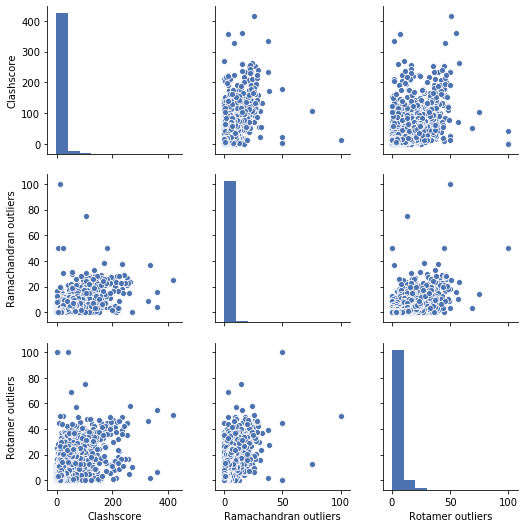

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(quality_df_filtered_columns)

After removing strong outliers and standardizing the data (setting the mean to be 0 and standard deviation to 1), the data presents itself as follows.

In [17]:
df_filtered = quality_df_filtered_columns.drop(quality_df_filtered_columns[(quality_df_filtered_columns.loc[:, "Rotamer outliers"] > 50) | (quality_df_filtered_columns.loc[:, "Ramachandran outliers"] > 45) | (quality_df_filtered_columns.loc[:, "Clashscore"] > 250)].index, axis=0)

scaler = StandardScaler()
scaler.fit(df_filtered)
df_rescaled = scaler.transform(df_filtered)
df_rescaled = pd.DataFrame(df_rescaled, columns=pca_columns)
df_rescaled.head()

,Clashscore,Ramachandran outliers,Rotamer outliers
0,-0.420900,NaN,NaN
1,0.664400,NaN,NaN
2,0.624424,-0.413883,-0.144226
3,-0.588458,NaN,NaN
4,-0.252492,-0.413883,0.151996


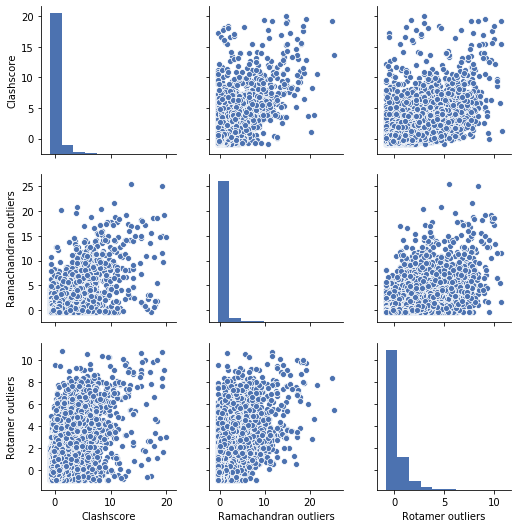

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(df_rescaled)

In [19]:
pca = PCA(svd_solver="full")
pca.fit(df_rescaled.dropna())
principal_components =pca.transform(df_rescaled.dropna())
df_pca = pd.DataFrame(data = principal_components, columns = ['PC 1', 'PC 2', 'PC3'])
df_pca.head()

,PC 1,PC 2,PC3
0,0.048873,0.053758,0.762770
1,-0.298850,-0.403398,0.036942
2,-0.026481,-0.052937,-0.127501
3,0.604840,-0.291181,0.275189
4,-0.171990,-0.242313,0.296805


Runnign Principle Component Analysis on the standardized data results in three principle components PC 1, PC 2, PC 3, explaining 76%, 15%, 9% variance, respectively.

In [20]:
pca.explained_variance_ratio_

array([0.76592098, 0.1445763 , 0.08950272])

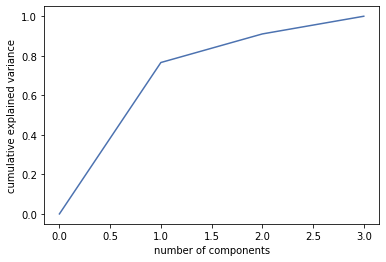

In [21]:
variance = np.array([0])
variance = np.append(variance, np.cumsum(pca.explained_variance_ratio_))
plt.plot(variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The eigenvectors of each principle component (presented below) show the linear combination coefficients of each quality measure.

In [22]:
df_eigen_vectors = pd.DataFrame(pca.components_,columns=df_rescaled.columns,index = ['PC 1','PC 2', 'PC 3'])
df_eigen_vectors

,Clashscore,Ramachandran outliers,Rotamer outliers
PC 1,0.586689,0.582150,0.562936
PC 2,0.247969,0.532610,-0.809220
PC 3,0.770913,-0.614351,-0.168121


**The result obtained in this analysis (explained variance of each principle component, coefficients (eigenvecor) of the first pronciple component) are almost identical to those presented in _"Multivariate Analyses of Quality Metrics for Crystal Structures in the PDB Archive"_ by Shao _et al._**

After performing the PCA analysis, we can compute the Q1 metric for all deposits in the PDB. Below a sample of the modified datasets: one without missing values and the other with imputed missing values.

In [23]:
q1_metrics = list(pca_columns)
q1_metrics.extend(["R free", "RSR Z-score"])

def add_Q1(df, scale_transformer, pca_transformer):
    full_df = df.copy().dropna(subset=q1_metrics)
    pca_df = pd.DataFrame(data=pca.transform(scaler.transform(full_df.loc[:, pca_columns])), 
                          columns=['PC1', 'PC2', 'PC3'],
                          index=full_df.index)
    
    pc1_p = pca_df.loc[:, "PC1"].rank(pct=True, ascending=False)
    rfree_p = full_df.loc[:, "R free"].rank(pct=True, ascending=False)
    zscore_p = full_df.loc[:, "RSR Z-score"].rank(pct=True, ascending=False)
    full_df.loc[:, "Q1"] = (pc1_p + rfree_p + zscore_p) / 3.0
    full_df.loc[:, "Q1 percentile"] = full_df.loc[:, "Q1"].rank(pct=True)
    
    return full_df
    
quality_q1_df = add_Q1(quality_df, scaler, pca)
quality_imputed_q1_df = add_Q1(quality_imputed_df, scaler, pca)

describe(quality_q1_df)
describe(quality_imputed_q1_df)

,Resolution,Date,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free,Q1,Q1 percentile
PDB code,,,,,,,,,,,
101m,2.07,1997-12-13,1997,16.75,0.00,3.17,0.65,0.157,0.202,0.648307,0.734144
102m,1.84,1997-12-15,1997,7.85,0.66,4.00,0.65,0.159,0.203,0.653031,0.741440
103m,2.07,1997-12-16,1997,10.14,0.00,4.00,0.65,0.158,0.216,0.631598,0.709031
104m,1.71,1997-12-18,1997,7.84,0.66,1.60,1.96,0.154,0.225,0.548630,0.578920
105m,2.02,1997-12-18,1997,16.07,0.00,2.40,0.65,0.174,0.268,0.453952,0.424223


Dataset rows: 111974
Dataset columns: 11


,Resolution,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free,Date,Q1,Q1 percentile
PDB code,,,,,,,,,,,
100d,1.90,1994.0,4.46,0.108252,4.779479,0.00000,0.145,0.196801,1994-12-05,0.750201,0.866922
101d,2.25,1994.0,17.22,1.360780,9.040809,1.29234,0.163,0.252000,1994-12-14,0.404836,0.346525
101m,2.07,1997.0,16.75,0.000000,3.170000,0.65000,0.157,0.202000,1997-12-13,0.665072,0.758983
102d,2.20,1994.0,2.49,-0.038806,4.486504,0.00000,0.155,0.208513,1994-12-15,0.754365,0.871724
102l,1.74,1992.0,6.44,0.000000,4.440000,1.84000,0.174,0.221498,1992-09-29,0.585856,0.640974


Dataset rows: 131194
Dataset columns: 11


## Crystallographic structure quality analysis

### Q1 percentiles over time and resolution

We analyzed how structure PDB quality changed with time and structure resolution. Structures were grouped by deposition year and resolution rounded to one decimal place and capped at 4 Å. The visual analysis presented below shows that:

1. The quality of structures is very strongly connected with their resolution
2. The quality of PDB structures has improved over time
3. The percentiles calculated using imputed data are almost identical to those calculated using only full deposits, but allows to view how the quality of the PDB changed throughout 45 rather than 25 years

In the following analysis of journals, we will use data with imputed missing values, and we will try to take into account deposition time and structure resolution.

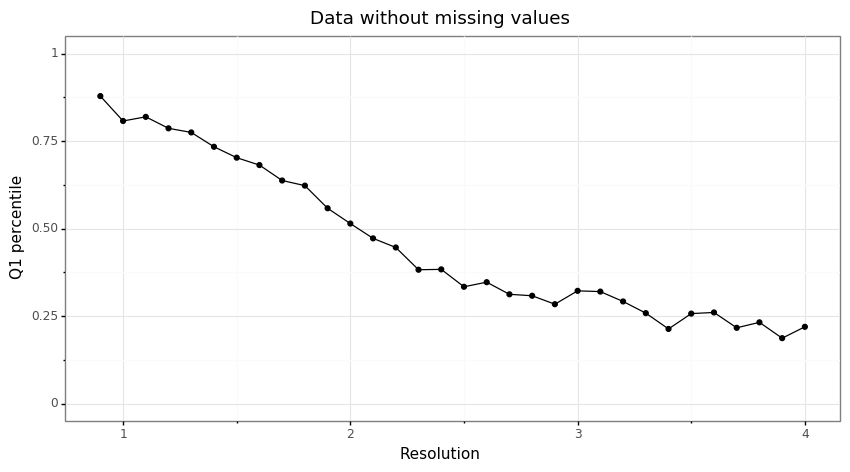

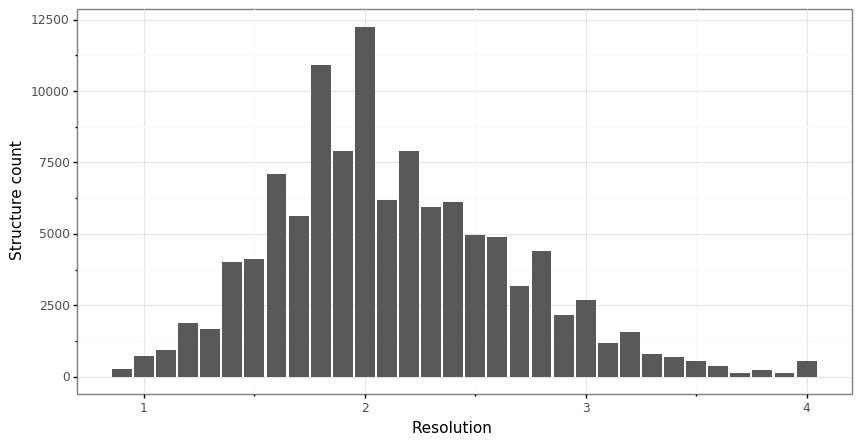

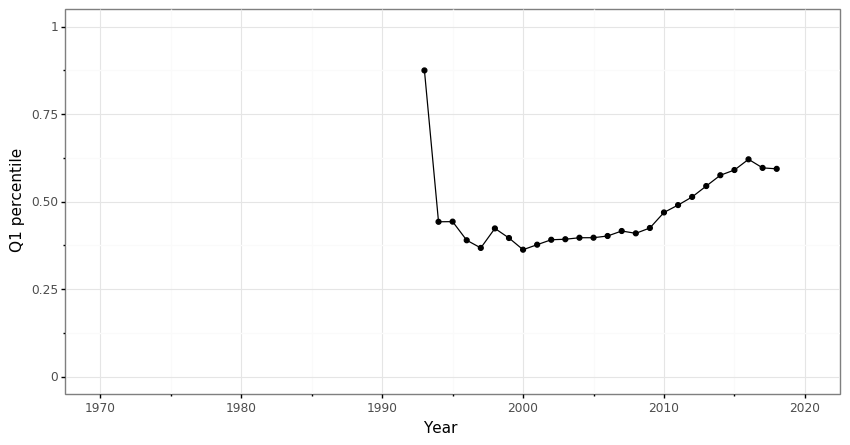

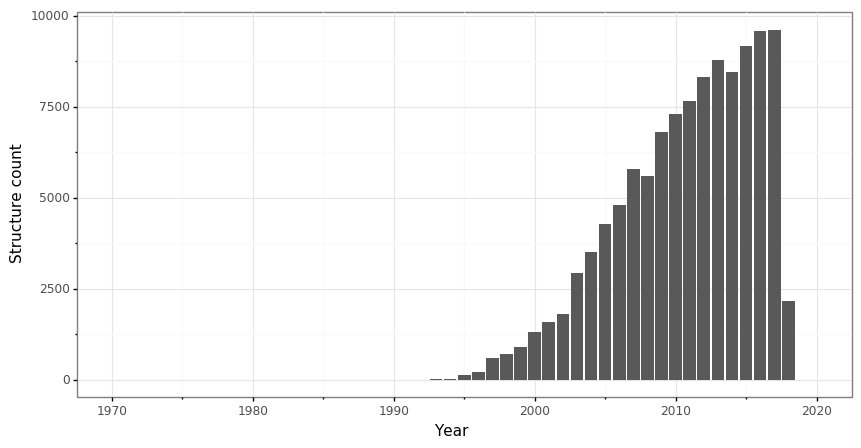

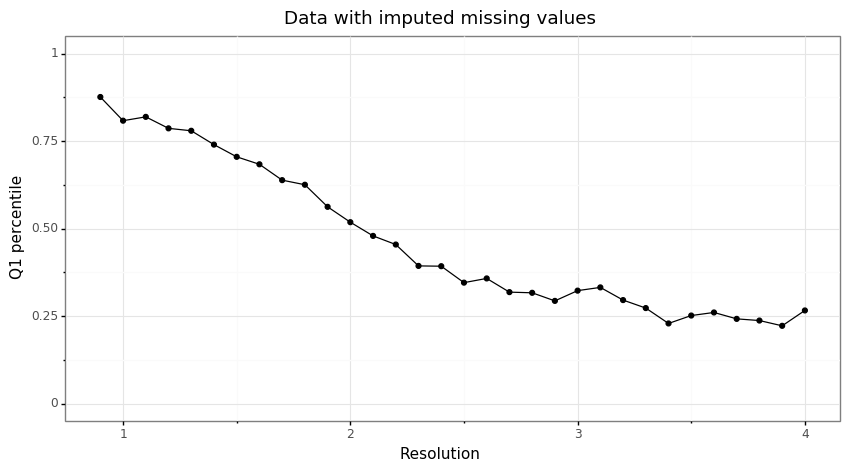

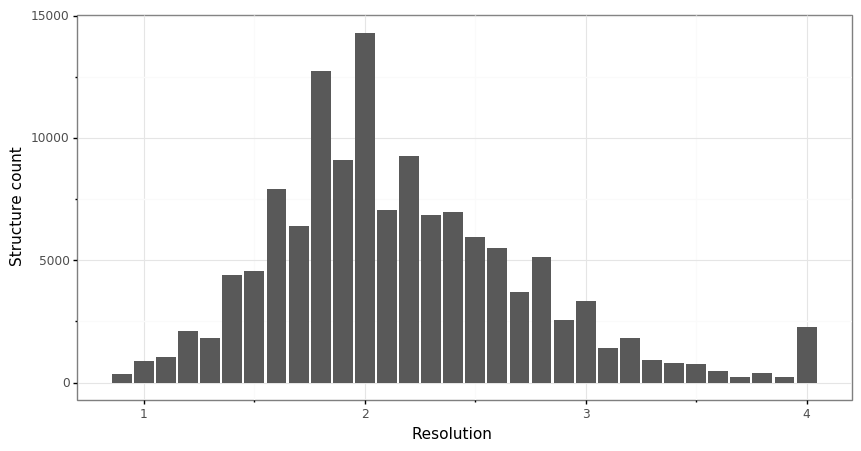

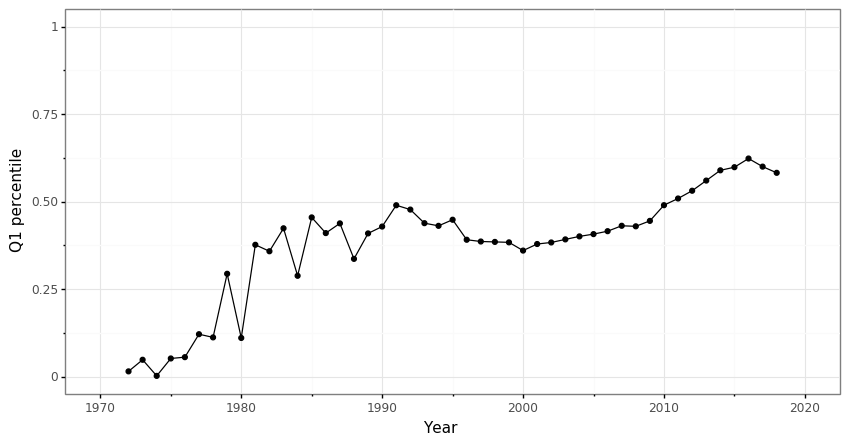

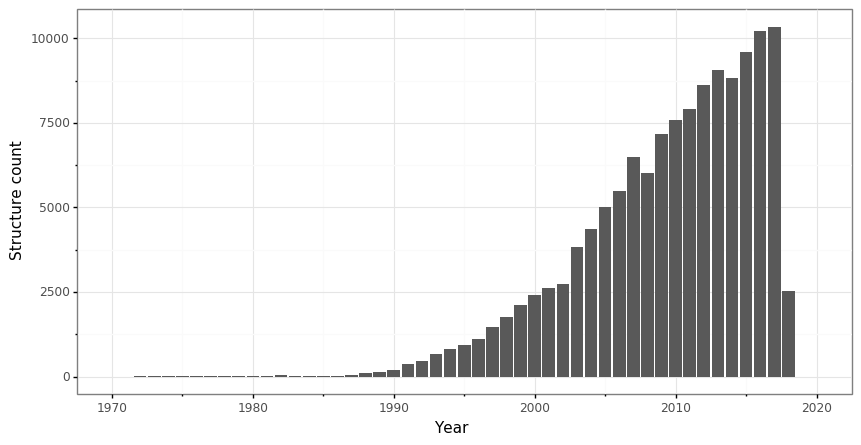

In [28]:
def plot_q1_analysis(df, title):
    plot_df = df.copy()
    plot_df.loc[:, "Resolution"] = plot_df.loc[:, "Resolution"].round(decimals=1)
    plot_df.loc[plot_df.loc[:, "Resolution"] > 4, "Resolution"] = 4
    plot_df.loc[plot_df.loc[:, "Resolution"] < 1, "Resolution"] = 0.9
    year_df = plot_df.groupby(['Year'], as_index=False).mean()
    count_df = plot_df.groupby(['Year'], as_index=False).count()
    resolution_df = plot_df.groupby(['Resolution'], as_index=False).mean()
    count_res_df = plot_df.groupby(['Resolution'], as_index=False).count()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        (ggplot(resolution_df, aes(x="Resolution", y="Q1 percentile")) + labs(title=title) +
         geom_point() + geom_line() + ylim(0, 1) + theme_bw()).draw();

        warnings.simplefilter("ignore")
        (ggplot(count_res_df, aes(x="Resolution", y="Q1 percentile")) +
         geom_bar(stat="identity") + ylab("Structure count") + theme_bw()).draw();

        warnings.simplefilter("ignore")
        (ggplot(year_df, aes(x="Year", y="Q1 percentile")) +
         geom_point() + geom_line() + xlim(1970, 2020) + ylim(0, 1) + theme_bw()).draw();

        warnings.simplefilter("ignore")
        (ggplot(count_df, aes(x="Year", y="Q1 percentile")) +
         geom_bar(stat="identity") + xlim(1970, 2020)  + ylab("Structure count")+ theme_bw()).draw();
        
plot_q1_analysis(quality_q1_df, "Data without missing values")
plot_q1_analysis(quality_imputed_q1_df, "Data with imputed missing values")

### Q(t) and Q(tr)

It can be noticed that there is a general trend of Q1 improving over the years. This is connected with the improvement of data collection procedure, hardware, software, and structure refinement standards. If one were to use Q1 calculated over all the analyzed years to rank journals, then journals with a longer history would be handicapped because they contain old structures. Even though a structure might have been impressively refined in its time, now it might be treated as a poorly refined structure according to current standards. One could recalculate Q1 percentiles separately for each decade or smaller time periods, but might not be sufficient (see the rapid improvement in the last 10 years) or would drastically reduce the data volume and effectively make journal comparison impossible. Therefore we propose to calculate Q1(t) --- the Q1 percentile calculated at time of structure deposition.

Moreover, seeing how strongly quality is related to resolution, we will perform two separate journal rankings: one using Q1(t) and one using Q1(t, r), i.e., the Q1 percentile calculated at time of structure deposition for a given resolution rounded to 1 decimal place and capped at 0.9 Å and 4 Å.

In [29]:
def add_Q1_t(q1_df):
    full_df = q1_df.sort_values(by=['Date']).copy()
    full_df.loc[:, "Q1(t) percentile"] = full_df.loc[:, "Q1"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True)
    
    return full_df

def add_Q1_tr(q1_df):
    full_df = q1_df.sort_values(by=['Date']).copy()
    full_df.loc[:, "Resolution group"] = full_df.loc[:, "Resolution"].round(decimals=1)
    full_df.loc[full_df.loc[:, "Resolution group"] > 4, "Resolution group"] = 4
    plot_df.loc[plot_df.loc[:, "Resolution"] < 1, "Resolution"] = 0.9
    full_df.loc[:, "Q1(tr) percentile"] = full_df.groupby('Resolution group')["Q1"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True).reset_index(level=0,drop=True)
    
    return full_df

journal_quality_imputed_df = pd.merge(journal_df, quality_imputed_q1_df, left_index=True, right_index=True)
journal_quality_imputed_df = add_Q1_t(journal_quality_imputed_df)
journal_quality_imputed_df = add_Q1_tr(journal_quality_imputed_df)
journal_quality_imputed_df.to_csv("results/journal_quality.csv")

In [31]:
describe(journal_quality_imputed_df)

,ISSN,Journal,Volume,Page,Publication year,Resolution,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free,Date,Q1,Q1 percentile,Q1(t) percentile,Resolution group,Q1(tr) percentile
PDB code,,,,,,,,,,,,,,,,,,,
1sbt,0006-291X,BIOCHEM BIOPHYS RES COMMUN,V. 45,337,1971.0,2.5,1972.0,95.46,6.59,10.73,5.453971,0.251807,0.309342,1972-08-11,0.092525,0.014696,1.000000,2.5,1.0
1mbn,0079-6808,PROG STEREOCHEM,V. 4,299,1969.0,2.0,1973.0,54.11,3.31,15.20,4.515475,0.214654,0.277364,1973-04-05,0.160213,0.051111,1.000000,2.0,1.0
2dhb,0028-0836,NATURE,V. 228,551,1970.0,2.8,1973.0,26.21,5.65,15.09,4.046463,0.229415,0.297561,1973-11-01,0.151089,0.044636,0.666667,2.8,1.0
3ldh,0022-2836,J MOL BIOL,V. 102,759,1976.0,3.0,1974.0,189.70,14.60,39.86,8.368748,0.311512,0.394878,1974-06-06,0.034463,0.001822,0.250000,3.0,1.0
2cha,0022-2836,J MOL BIOL,V. 68,187,1972.0,2.0,1975.0,23.29,1.73,16.67,3.769948,0.199410,0.265469,1975-01-01,0.223735,0.103953,1.000000,2.0,1.0


Dataset rows: 126739
Dataset columns: 19


In [33]:
MIN_STRUCTURES_IN_JOURNAL = 100
PERCENTILE_OFFSET = 0

ranking_df = journal_quality_imputed_df.iloc[PERCENTILE_OFFSET:, :].copy()
venue_count_df = ranking_df.groupby(['Journal'], as_index=False).size()
venue_count_df = venue_count_df.rename("Structure count")
venue_count_df = venue_count_df.sort_values(ascending=False)
popular_venues = venue_count_df[venue_count_df >= MIN_STRUCTURES_IN_JOURNAL].index
top25_venues = venue_count_df.iloc[:25].index

ranking_df = ranking_df.loc[ranking_df.Journal.isin(popular_venues), :]
ranking_of_25_most_popular_df = ranking_df.loc[ranking_df.Journal.isin(top25_venues), :]

### Journal ranking according to Q(t)

In [129]:
def display_ranking(ranking_df, measure):
    venue_df = ranking_df.groupby(['Journal'], as_index=False).mean()
    venue_df = pd.merge(venue_df, venue_count_df, right_index=True, left_on="Journal")
        
    measure_ranking_df = venue_df.sort_values(by=measure, ascending=False).loc[:, ["Journal", measure, "Structure count"]]
    measure_ranking_df.insert(loc=0, column='Rank', value=(np.arange(len(measure_ranking_df)) + 1))
    measure_ranking_df = measure_ranking_df.set_index('Rank')
    measure_ranking_df.to_csv("results/ranking " + measure + ".csv")
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(measure_ranking_df)
        
display_ranking(ranking_df, "Q1(t) percentile")

,Journal,Q1(t) percentile,Structure count
Rank,,,
1,TUBERCULOSIS (EDINB),0.842394,132
2,CHEMISTRY,0.721113,189
3,EUR J MED CHEM,0.720975,288
4,CHEM COMMUN,0.714612,230
5,CHEMBIOCHEM,0.709044,478
6,J SYNCHROTRON RADIAT,0.708567,131
7,IUCRJ,0.701620,133
8,ORG BIOMOL CHEM,0.698937,147
9,ACS CATAL,0.693103,125


### Journal ranking according to Q(tr)

In [130]:
display_ranking(ranking_df, "Q1(tr) percentile")

,Journal,Q1(tr) percentile,Structure count
Rank,,,
1,TUBERCULOSIS (EDINB),0.867761,132
2,EUR J MED CHEM,0.706974,288
3,CHEMBIOCHEM,0.678083,478
4,MBIO,0.673691,115
5,ORG BIOMOL CHEM,0.668946,147
6,CHEMISTRY,0.655681,189
7,ACS CATAL,0.650898,125
8,BIOCHEM J,0.643951,948
9,CHEM COMMUN,0.643799,230


## Rankings over time

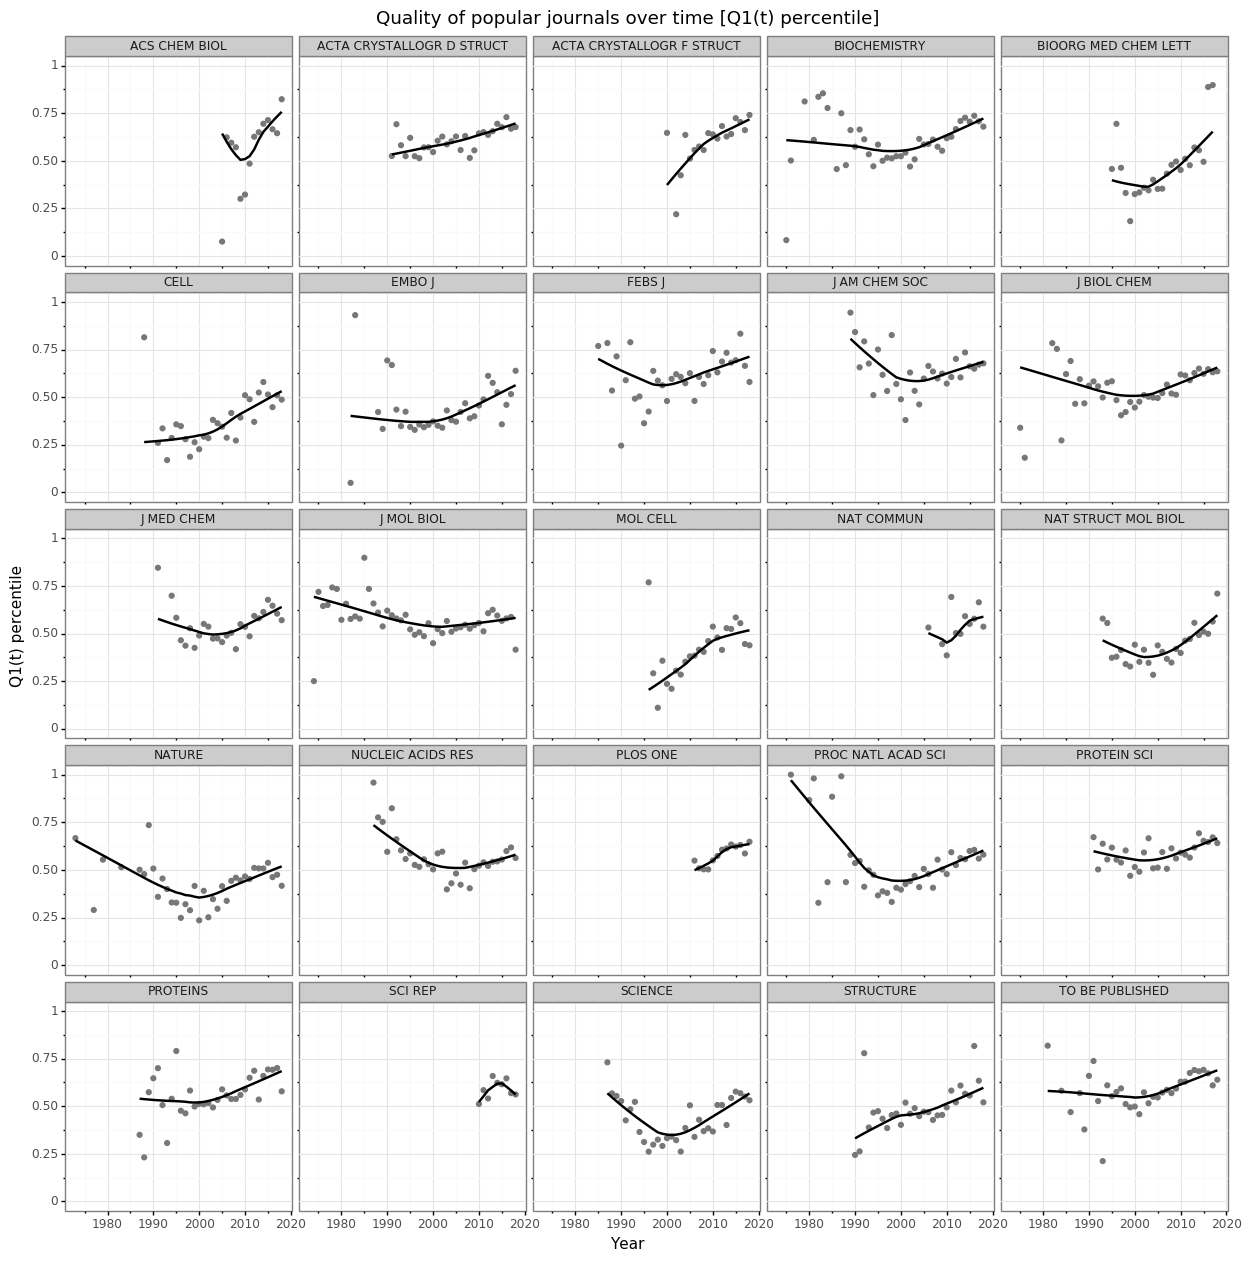

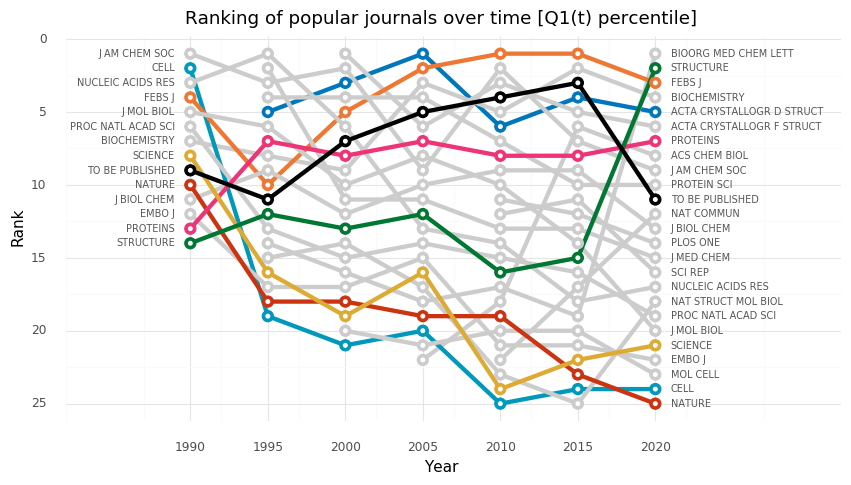

In [137]:
def plot_rankings(ranking_df, measure):
    venue_df = ranking_df.groupby(['Journal'], as_index=False).mean()
    venue_df = pd.merge(venue_df, venue_count_df, right_index=True, left_on="Journal")
        
    year_venue_df = ranking_of_25_most_popular_df.groupby(['Year', 'Journal'], as_index=False).mean()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        (ggplot(year_venue_df, aes(x="Year", y=measure)) + 
         geom_point(color="#777777") +
         facet_wrap('~Journal', ncol=5) + 
         geom_smooth() +
         ylim(0,1) + 
         theme_bw() + 
         theme(legend_position = "none", figure_size=(15, 15)) +
         labs(title="Quality of popular journals over time [" + measure + "]")
        ).draw();
        
    measure_ranking_df = venue_df.sort_values(by=measure, ascending=False).loc[:, ["Journal", measure, "Structure count"]]
    measure_ranking_df.insert(loc=0, column='Rank', value=(np.arange(len(measure_ranking_df)) + 1))
    measure_ranking_df = measure_ranking_df.set_index('Rank')
    measure_ranking_df.to_csv("results/ranking " + measure + ".csv")

    TOP_N = 25
    COLORED_JOURNALS = ["STRUCTURE", "SCIENCE", "NATURE", "FEBS J", "PROTEINS", "ACTA CRYSTALLOGR D STRUCT", "TO BE PUBLISHED", "CELL"]

    year_venue_df_over_time = ranking_of_25_most_popular_df.copy()
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year <= 1990), "Year"] = 1990
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1990) & (year_venue_df_over_time.Year <= 1995), "Year"] = 1995
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1995) & (year_venue_df_over_time.Year <= 2000), "Year"] = 2000
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2000) & (year_venue_df_over_time.Year <= 2005), "Year"] = 2005
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2005) & (year_venue_df_over_time.Year <= 2010), "Year"] = 2010
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2010) & (year_venue_df_over_time.Year <= 2015), "Year"] = 2015
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2015), "Year"] = 2020

    year_venue_df_over_time = year_venue_df_over_time.groupby(['Year', 'Journal'], as_index=False).mean().copy()
    year_venue_df_over_time.loc[:, "Rank"] = year_venue_df_over_time.groupby(['Year'])[measure].rank(ascending=False)
    year_venue_df_over_time.loc[:, "Journal color"] = "zzz"
    year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal color"] = year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal"] 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        (ggplot(year_venue_df_over_time, aes(x = "Year", y = "Rank", group = "Journal")) +
         geom_line(aes(color = "Journal color", alpha = 1), size = 1.75) +
         geom_point(aes(color = "Journal color", alpha = 1), size = 4) +
         geom_point(color = "#FFFFFF", size = 1) +
         scale_y_reverse(breaks = range(1, TOP_N + 1)) +
         scale_x_continuous(breaks = range(1980, 2035, 5), minor_breaks = range(1982, 2033, 5)) +
         geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.min(), :],
                   aes(label = "Journal", x = year_venue_df_over_time.Year.min()-1), ha="right",color = "#555555", size = 7) +
         geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.max(), :],
                   aes(label = "Journal", x = year_venue_df_over_time.Year.max()+1), ha="left", color = "#555555", size = 7) +
         ylim(TOP_N, 1) + 
         theme_minimal() + 
         theme(legend_position = "none") +
         labs(title = "Ranking of popular journals over time [" + measure + "]") + 
           scale_color_manual(values = ["#0077BB","#0099BB","#EE7733","#CC3311", "#EE3377", "#DDAA33", "#007733", "#000000", "#CCCCCC"])
        ).draw();
        
plot_rankings(ranking_df, "Q1(t) percentile")

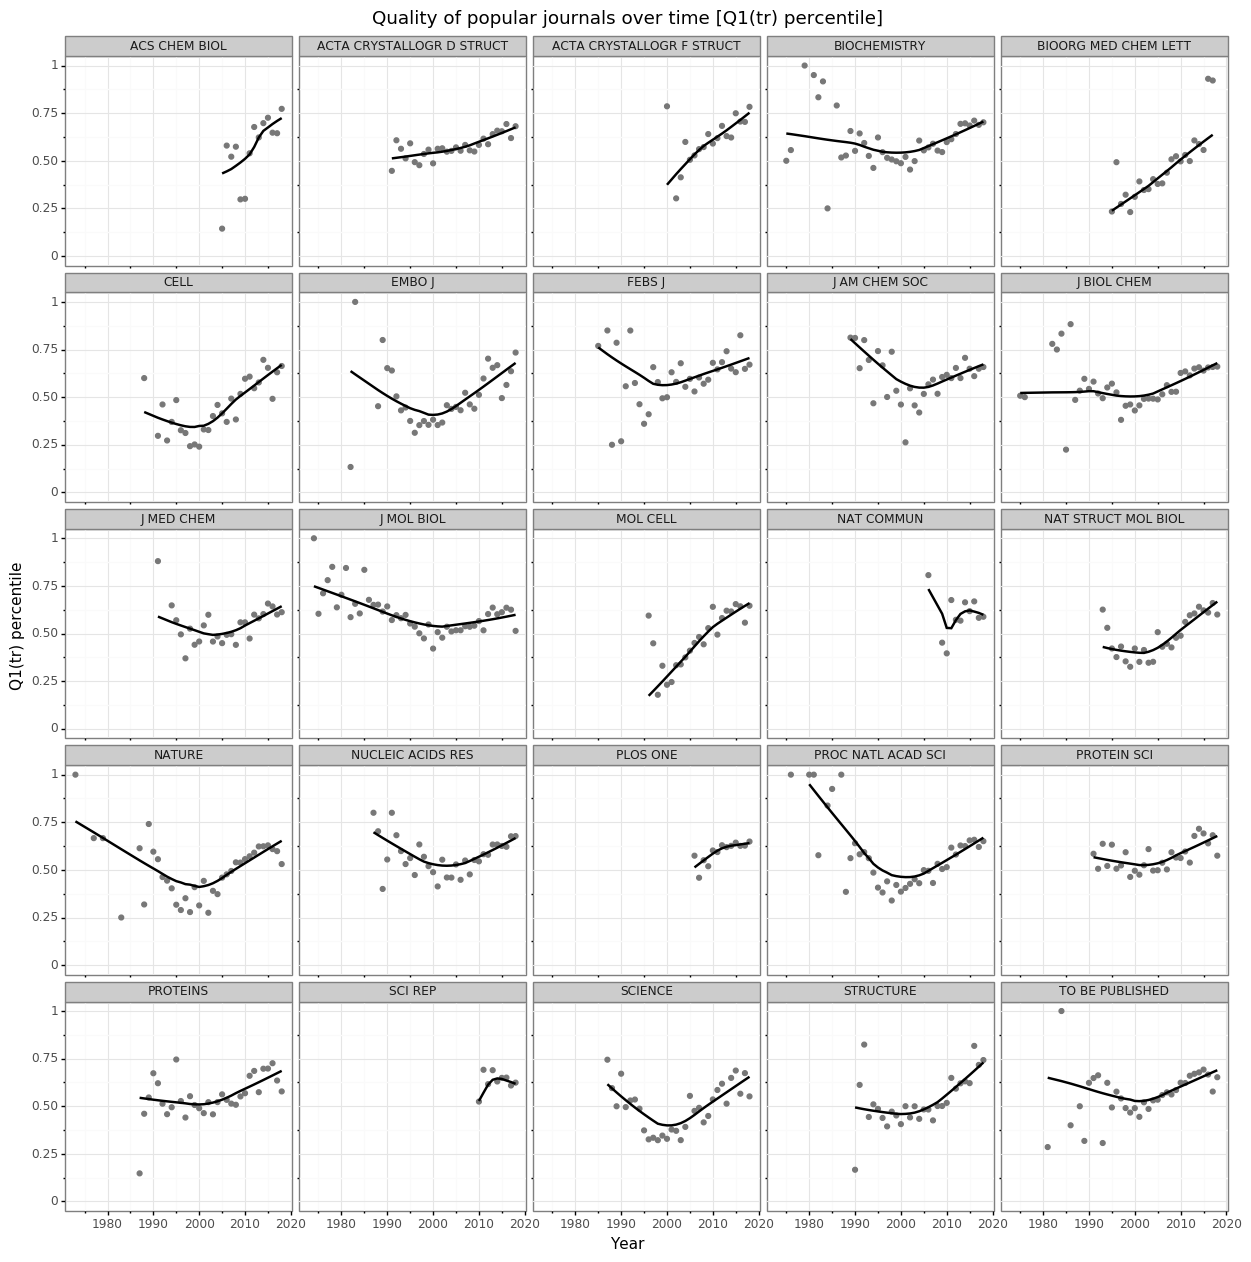

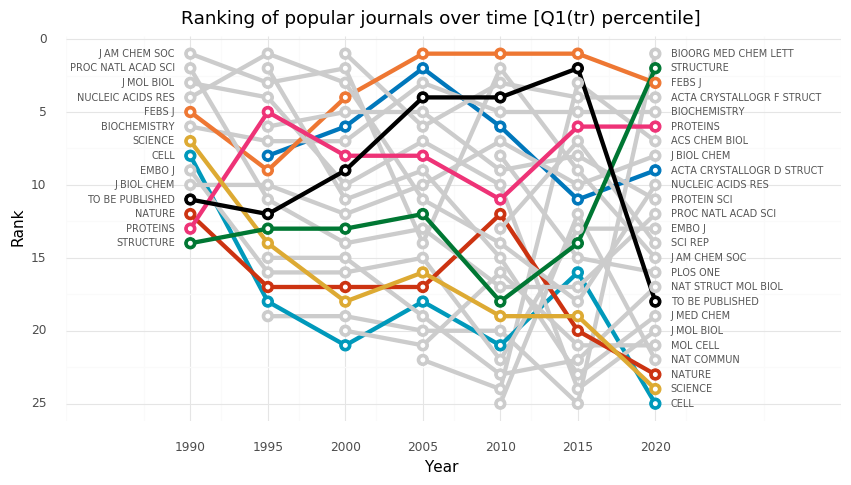

In [138]:
plot_rankings(ranking_df, "Q1(tr) percentile")